# Setup, imports


In [2]:
# Add the parent directory to path
import sys

sys.path.append("..")


In [3]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

from tqdm import tqdm

"""Policy imports"""
from utils.utils import simulate_policy

%matplotlib inline

In [4]:
!which python3

/Users/mohahf19/micromamba/envs/annrl2023/bin/python3


['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


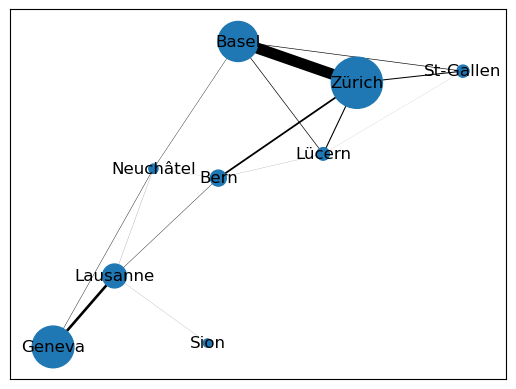

In [5]:
dyn = ModelDynamics("../config/switzerland.yaml")  # load the switzerland map
print(dyn.cities)
dyn.draw_map()


# Question 3.a


In [6]:
from math import comb
from typing import Callable

action = {  # DO NOTHING
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

# Actually, actions can be any combination of the four.
action_value_dict = {0: "confinement", 1: "isolation", 2: "hospital", 3: "vaccinate"}

num_actions = 2**1  # If only for confinement
num_cities = len(dyn.cities)
num_features_per_city = 2  # infected, dead
num_observation_features = num_cities * (num_features_per_city * 7)


def observation_to_tensor(
    obs: Observation,
    dyn: ModelDynamics,
    features_per_city: int = 7 * num_features_per_city,
) -> torch.Tensor:
    """Convers the observation object to a torch Tensor
    The tensor is defined as: for each city, population (1), infected (7), dead (7)
    """
    num_cities = len(dyn.cities)
    output = torch.zeros(num_cities * features_per_city)
    for i, city in enumerate(dyn.cities):
        # output[i * features_per_city] = obs.pop[city]
        # output[i * features_per_city + 1 : i * features_per_city + 8] =  torch.tensor(obs.city[city].infected)
        # output[i * features_per_city + 8 : i * features_per_city + 15] =  torch.tensor(obs.city[city].dead)
        output[i * features_per_city : i * features_per_city + 7] = (
            torch.tensor(obs.city[city].infected) / obs.pop[city]
        ) ** (1 / 4)
        output[i * features_per_city + 7 : i * features_per_city + 14] = (
            torch.tensor(obs.city[city].dead) / obs.pop[city]
        ) ** (1 / 4)
        
    return output


"""Loading the environment"""
env = Env(
    dyn,  # We pass the dynamical model to the environment
    action_space=spaces.Discrete(
        num_actions
    ),  # Here one could pass an openai gym action space that can then be sampled
    observation_space=spaces.Box(
        low=0, high=np.inf, shape=(num_observation_features,), dtype=float
    ),  # Here one could pass an openai gym obs space that can then be sampled
)


def action_value_to_actions(action_value: int) -> list[int]:
    bin_str = [int(char) for char in reversed(bin(action_value)[2:])]
    actions = []
    for i, val in enumerate(bin_str):
        if val == 1:
            actions.append(i)
    return actions


def create_action(
    action: int,
    action_value_to_actions: Callable = action_value_to_actions,
    action_value_dict: dict = action_value_dict,
) -> dict[str, bool]:
    """Creates a policy from the encoded action value"""
    actions = action_value_to_actions(action)
    policy = {x: False for x in action_value_dict.values()}
    policy.update({action_value_dict[x]: True for x in actions})
    return policy


print(
    env.observation_space.sample().shape,
    (a := env.action_space.sample()),
    action_value_to_actions(a),
    [action_value_dict[x] for x in action_value_to_actions(a)],
    create_action(0),  # no action
    create_action(1),  # confinement
    create_action(1 + 2),  # confine + isolate
)


(126,) 0 [] [] {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False} {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False} {'confinement': True, 'isolation': True, 'hospital': False, 'vaccinate': False}


In [7]:
num_cities * (num_features_per_city * 7)


126

In [8]:
import random
from collections import namedtuple, deque

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, bs: int):
        n_to_sample = bs if bs < len(self.memory) else len(self.memory)
        return random.sample(self.memory, n_to_sample)

    def __len__(self) -> int:
        return len(self.memory)


In [14]:
import torch
from torch import nn, optim


class DQNModel(nn.Module):
    def __init__(self, obs_dim: int, actions_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Linear(32, actions_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


dqn = DQNModel(env.observation_space.shape[0], 2**1)
obs = torch.randn(10, env.observation_space.shape[0])
output = dqn(obs)
best_actions = output.argmax(axis=1)
action_lists = [action_value_to_actions(x) for x in best_actions]
print(action_lists)
action_values = [
    [action_value_dict[x] for x in action_list] for action_list in action_lists
]
print(action_values)
# print(action, actions, output, len(output))


[[0], [0], [0], [], [], [0], [0], [0], [0], [0]]
[['confinement'], ['confinement'], ['confinement'], [], [], ['confinement'], ['confinement'], ['confinement'], ['confinement'], ['confinement']]


In [15]:
def select_action(output: torch.Tensor, epsilon: float) -> int:
    """Selects an action based on the output of the DQN."""
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(output))
    else:
        return output.argmax().item()


In [16]:
def simulate_policy(policy_net: nn.Module, eval_seed_sequences: np.ndarray, discount_factor: float, device: str, logging:bool= False) -> list[float]:
    rewards = []
    for eval_seed in eval_seed_sequences:
        cumulative_reward = 0
        curr_discount_factor = 1
        done = False
        obs, info = env.reset(seed=eval_seed)
        obs_tensor = observation_to_tensor(obs, dyn).to(device)
        policy_net.to(device)
        
        while not done:
            policy_output = policy_net(obs_tensor)
            action = select_action(policy_output, epsilon=0)
            curr_action = create_action(action)
            if logging:
                print(action, end=" ")
            obs, reward, done, info = env.step(curr_action)
            reward = reward.to(device)
            
            cumulative_reward += curr_discount_factor * reward
            curr_discount_factor *= discount_factor
        rewards.append(cumulative_reward.item())
        if logging:
            print()
            print(info.total)
    return rewards

In [17]:
# optimize_model(policy_net, memory, optimizer, batch_size, discount_factor)
def optimize_model(
    policy_net: nn.Module,
    target_net: nn.Module,
    memory: ReplayMemory,
    optimizer: torch.optim,
    batch_size: int,
    discount_factor: float,
    device: str = "cpu",
) -> None:
    """Optimizes the policy network based on a batch of transitions sampled from the replay memory. Only optmise if the replay memory is larger than the batch size."""
    # assert batch_size <= len(memory), "Insufficient memory to sample a batch."
    
    def criterion(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.sum(x-y)
    
    transitions = memory.sample(batch_size)

    """ChatGPT Explanation:
    The code batch = Transition(*zip(*transitions)) takes the list of transitions transitions and converts it into a batch of transitions, where each element of the batch is a tuple containing the corresponding elements from all transitions.

    Let's break down the code:

    zip(*transitions) takes all the transitions and groups together all elements at the same position in each tuple, effectively transposing the list of tuples. For example, if the original transitions list contains (s1, a1, s2, r1) and (s2, a2, s3, r2), the result of zip(*transitions) will be (s1, s2), (a1, a2), (s2, s3), (r1, r2).

    * before zip unpacks the list transitions into separate arguments to zip.

    Transition(*zip(*transitions)) uses argument unpacking again, but this time for the Transition namedtuple. It unpacks the resulting tuples of zip(*transitions) into four separate arguments (state, action, next_state, reward) and creates a new instance of Transition for each element in the batch.

    So, batch is a namedtuple of batches, where each element in the batch corresponds to all states, actions, next_states and rewards from all the transitions. For example, if the original transitions list contains three transitions, then batch.state would be a tuple of the three states, batch.action would be a tuple of the three actions, and so on.
    """
    batch = Transition(*zip(*transitions))

    state_b = torch.stack(batch.state).to(device)
    next_state_b = torch.stack(batch.next_state).to(device)
    action_b = torch.tensor(batch.action).to(device)
    reward_b = torch.tensor(batch.reward).to(device)
    
    policy_net.to(device)
    target_net.to(device)

    state_action_values = policy_net(state_b).gather(
        1, action_b.unsqueeze(1)
    )  # Computes Q_theta(s_t, a_t)
    next_state_values = target_net(next_state_b).max(1)[
        0
    ]  # Computes \hat{Q}(s_t+1) = max_a \hat{Q}(s_t+1, a)

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * discount_factor) + reward_b

    loss = criterion(expected_state_action_values, state_action_values.squeeze()) # Difference between the expected Q values and the actual Q values
    # loss = expected_state_action_values - state_action_values.squeeze() # Difference between the expected Q values and the actual Q values

    # Optimize the model now
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [23]:
num_episodes = 200
seed = 41
learning_rate = 5e-3
discount_factor = 0.9
target_update_per = 5 # update target network every 5 episodes
evaluate_per = 20 # evaluate every 20 episodes
num_eval_episodes = 20
buffer_size = 20_000
batch_size = 2**11
epsilon = 0.7
device="mps"

torch.manual_seed(seed)
np.random.seed(seed)
env_seed_sequences = np.random.randint(0, 1000, size=num_episodes)
eval_seed_sequences = np.random.randint(0, 1000, size=num_eval_episodes)

assert len(env_seed_sequences) == num_episodes
assert len(eval_seed_sequences) == num_eval_episodes


## Initializations
obs, info = env.reset(seed=seed)
n_actions = env.action_space.n
n_observations = observation_to_tensor(obs, dyn).shape[0]

## Policy and target networks
policy_net = DQNModel(n_observations, n_actions).to(device)
target_net = DQNModel(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())


initial_net = DQNModel(n_observations, n_actions)
initial_net.load_state_dict(policy_net.state_dict())

memory = ReplayMemory(buffer_size)
optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate)

tr_losses = []

tr_trace, eval_trace_mean, eval_trace_std = [], [], []
has_logged_started_training_message = False


for num_episode in tqdm(range(num_episodes)):
    obs, info = env.reset(seed=env_seed_sequences[num_episode])
    obs_tensor = observation_to_tensor(obs, dyn).to(device)
    
    done = False
    
    cumulative_tr_reward = 0
    curr_discount_factor = 1
    while not done: # play the episode
        policy_output = policy_net(obs_tensor)
        action = select_action(policy_output, epsilon=epsilon)
        
        curr_action = create_action(action)
        
        obs, reward, done, info = env.step(curr_action)
        new_obs_tensor = observation_to_tensor(obs, dyn).to(device)
        reward = reward.to(device)
        
        memory.push(obs_tensor, action, new_obs_tensor, reward)
        
        cumulative_tr_reward += curr_discount_factor * reward
        curr_discount_factor *= discount_factor
        
        
        if batch_size <= len(memory):
            if not has_logged_started_training_message:
                print("Started training")
                has_logged_started_training_message = True
                
            loss_val = optimize_model(policy_net, target_net, memory, optimizer, batch_size, discount_factor, device=device)
            tr_losses.append(loss_val)
            # print(loss_val)
        
        # loss_val = optimize_model(policy_net, target_net, memory, optimizer, batch_size, discount_factor, device=device)
        # tr_losses.append(loss_val)
    tr_trace.append(cumulative_tr_reward.item())
                
    
    if num_episode % target_update_per == 0:
        target_net.load_state_dict(policy_net.state_dict())
    

    if num_episode % evaluate_per == 0 or num_episode == num_episodes-1:
        eval_rewards = simulate_policy(policy_net, eval_seed_sequences, discount_factor=discount_factor, device=device) # one reward per eval episode, so a 20 length list
        eval_trace_mean.append(np.mean(eval_rewards))
        eval_trace_std.append(np.std(eval_rewards))
        print(f"Episode {num_episode} | Eval reward mean: {np.mean(eval_rewards)} | Eval reward std: {np.std(eval_rewards)}")
    
    
    

  0%|          | 1/200 [00:06<22:29,  6.78s/it]

Episode 0 | Eval reward mean: -144.4912763595581 | Eval reward std: 40.39180420187144


 10%|█         | 21/200 [00:19<06:40,  2.24s/it]

Episode 20 | Eval reward mean: -144.4912763595581 | Eval reward std: 40.39180420187144


 20%|██        | 41/200 [00:32<05:53,  2.23s/it]

Episode 40 | Eval reward mean: -144.4912763595581 | Eval reward std: 40.39180420187144


 30%|███       | 61/200 [00:45<05:09,  2.23s/it]

Episode 60 | Eval reward mean: -144.4912763595581 | Eval reward std: 40.39180420187144


 34%|███▍      | 68/200 [00:47<01:03,  2.07it/s]

Started training


 40%|████      | 81/200 [03:29<27:41, 13.96s/it]

Episode 80 | Eval reward mean: -144.4912763595581 | Eval reward std: 40.39180420187144


 50%|█████     | 101/200 [07:38<23:22, 14.17s/it]

Episode 100 | Eval reward mean: 2.718401861190796 | Eval reward std: 0.8395357267780867


 60%|██████    | 121/200 [11:47<18:37, 14.14s/it]

Episode 120 | Eval reward mean: 2.718401861190796 | Eval reward std: 0.8395357267780867


 70%|███████   | 141/200 [15:55<13:42, 13.95s/it]

Episode 140 | Eval reward mean: 2.718401861190796 | Eval reward std: 0.8395357267780867


 80%|████████  | 161/200 [20:02<09:03, 13.93s/it]

Episode 160 | Eval reward mean: 2.718401861190796 | Eval reward std: 0.8395357267780867


 90%|█████████ | 181/200 [24:09<04:24, 13.90s/it]

Episode 180 | Eval reward mean: 2.718401861190796 | Eval reward std: 0.8395357267780867


100%|██████████| 200/200 [28:06<00:00,  8.43s/it]

Episode 199 | Eval reward mean: 2.718401861190796 | Eval reward std: 0.8395357267780867


In [24]:
from pathlib import Path
model_save_path = Path("../models")
model_save_path.mkdir(exist_ok=True)

torch.save(policy_net.state_dict(), model_save_path / "dqn_binary_q3a.pt")

Text(0.5, 1.0, 'Eval trace')

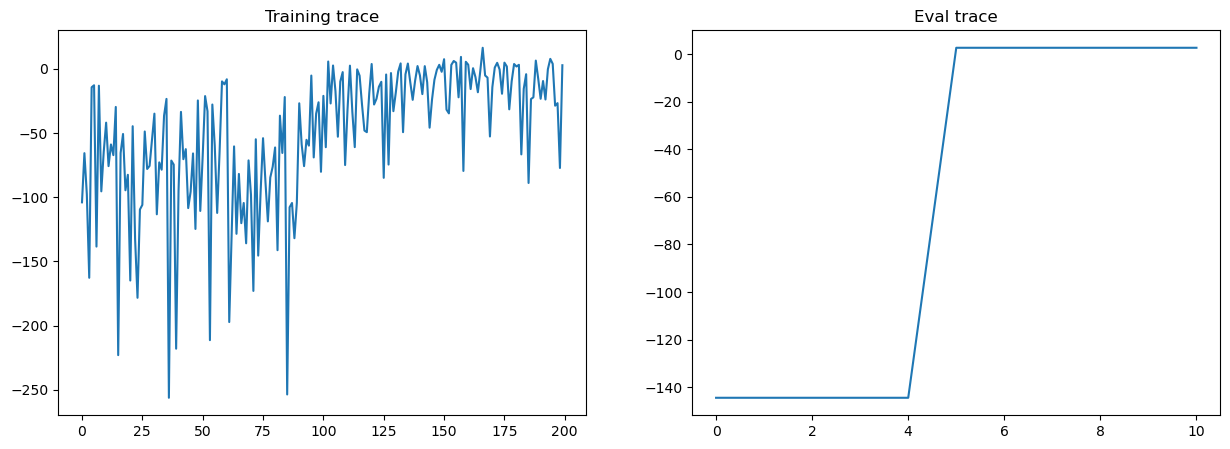

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].plot(tr_trace, label="training rewards")
ax[0].set_title("Training trace")

ax[1].plot(eval_trace_mean, label="eval mean reward")
ax[1].set_title("Eval trace")

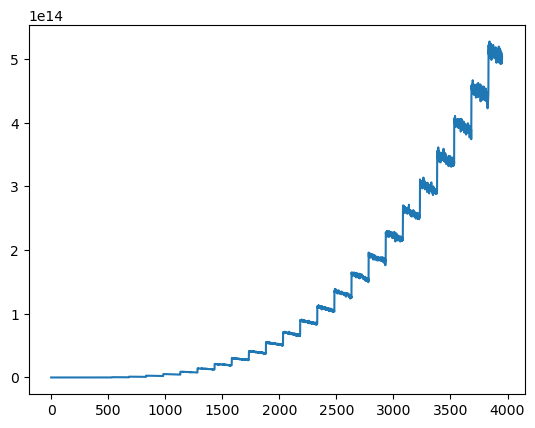

In [26]:
plt.plot(tr_losses)

In [27]:
eval_rewards = simulate_policy(policy_net, eval_seed_sequences, discount_factor=discount_factor, device=device, logging=True)
print(eval_rewards)

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
Parameters(day=210, suceptible=3623942, exposed=0, infected=0, recovered=129572, dead=762, initial_population=3749837)
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
Parameters(day=210, suceptible=3564906, exposed=0, infected=0, recovered=184043, dead=1153, initial_population=3749837)
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
Parameters(day=210, suceptible=3670599, exposed=0, infected=0, recovered=78787, dead=449, initial_population=3749837)
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
Parameters(day=210, suceptible=3721231, exposed=0, infected=0, recovered=28623, dead=111, initial_population=3749837)
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
Parameters(day=210, suceptible=3744210, exposed=0, infected=0, recovered=5614, dead=21, initial_population=3749837)
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
Parameters(day=210, suceptible=3744708, exp

In [28]:
eval_rewards

[2.0206966400146484,
 1.0459535121917725,
 2.278308391571045,
 3.33493971824646,
 3.52547287940979,
 3.5597598552703857,
 3.2900826930999756,
 3.525785207748413,
 3.3509881496429443,
 3.510995626449585,
 2.190601348876953,
 1.940633773803711,
 2.7277133464813232,
 1.8736920356750488,
 3.4556195735931396,
 1.9714550971984863,
 3.467787981033325,
 3.328505277633667,
 3.024456739425659,
 0.944589376449585]

In [29]:
eval_trace_mean

[-144.4912763595581,
 -144.4912763595581,
 -144.4912763595581,
 -144.4912763595581,
 -144.4912763595581,
 2.718401861190796,
 2.718401861190796,
 2.718401861190796,
 2.718401861190796,
 2.718401861190796,
 2.718401861190796]